In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebr        
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
import seaborn as sns
from pylab import rcParams
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE


from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support, accuracy_score)
from sklearn.linear_model import LogisticRegression

from keras.models import Model, load_model, Sequential
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 12, 5
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/creditcardfraud/creditcard.csv


# Reading Data:

In [4]:
df = pd.read_csv('/kaggle/input/creditcardfraud/creditcard.csv')

# Exploring Data:

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [7]:
df.groupby('Class')['Amount'].agg([np.max, np.mean, np.min])

,amax,mean,amin
Class,,,
0,25691.16,88.291022,0.0
1,2125.87,122.211321,0.0


In [8]:
df[df.Amount == 0]['Class'].value_counts() # Amount == 0 ??????????????

0    1798
1      27
Name: Class, dtype: int64

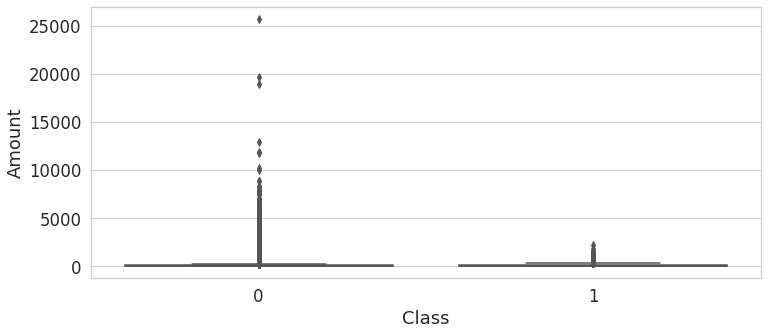

In [9]:
sns.boxplot('Class', 'Amount', data = df);

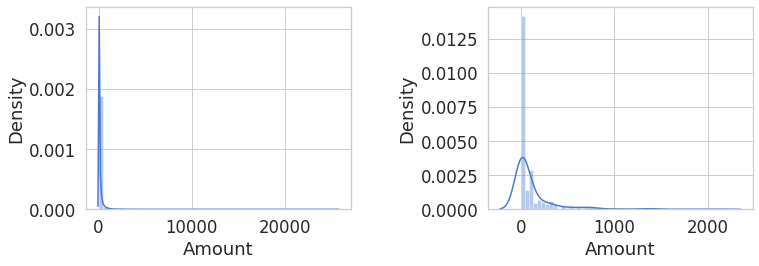

In [10]:
fig, ax = plt.subplots(1,2)
sns.distplot(df[df.Class == 0]['Amount'], ax = ax[0])
sns.distplot(df[df.Class == 1]['Amount'], ax = ax[1])
fig.tight_layout(pad=3.0)
plt.show()

In [11]:
# Make A copy of data
dfc = df.copy()

In [12]:
dfc['Log_Amount'] = np.log1p(dfc['Amount'])

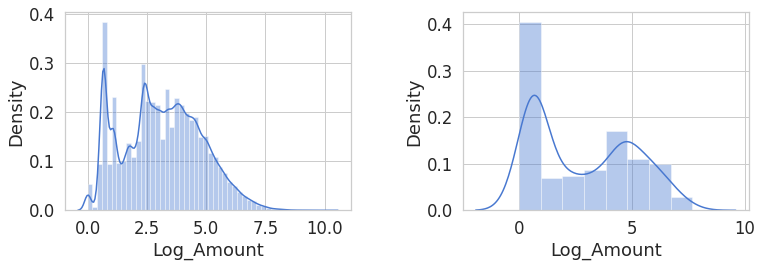

In [13]:
fig, ax = plt.subplots(1,2)
sns.distplot(dfc[dfc.Class == 0]['Log_Amount'], ax = ax[0])
sns.distplot(dfc[dfc.Class == 1]['Log_Amount'], ax = ax[1])
fig.tight_layout(pad=3.0)
plt.show()          #better

# Splitting Data:
*Split the data into 3 samples: (80% normal, 10% both (for val) and 10% both(for test).*

In [14]:
# Before Splitting
dfc.drop(columns = ['Time', 'Amount'], inplace = True)

In [15]:
normal = dfc[dfc.Class == 0].sample(frac = .8, random_state= 42)
# test
normal.shape

(227452, 30)

In [16]:
normal.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Log_Amount
138028,1.314539,0.590643,-0.666593,0.716564,0.301978,-1.125467,0.388881,-0.288390,-0.132137,-0.597739,...,-0.170307,-0.429655,-0.141341,-0.200195,0.639491,0.399476,-0.034321,0.031692,0,0.565314
63099,-0.798672,1.185093,0.904547,0.694584,0.219041,-0.319295,0.495236,0.139269,-0.760214,0.170547,...,0.202287,0.578699,-0.092245,0.013723,-0.246466,-0.380057,-0.396030,-0.112901,0,1.644805
73411,-0.391128,-0.245540,1.122074,-1.308725,-0.639891,0.008678,-0.701304,-0.027315,-2.628854,2.051312,...,-0.133485,0.117403,-0.191748,-0.488642,-0.309774,0.008100,0.163716,0.239582,0,2.772589
164247,-0.060302,1.065093,-0.987421,-0.029567,0.176376,-1.348539,0.775644,0.134843,-0.149734,-1.238598,...,0.355576,0.907570,-0.018454,-0.126269,-0.339923,-0.150285,-0.023634,0.042330,0,4.060443
148999,1.848433,0.373364,0.269272,3.866438,0.088062,0.970447,-0.721945,0.235983,0.683491,1.166335,...,0.103563,0.620954,0.197077,0.692392,-0.206530,-0.021328,-0.019823,-0.042682,0,0.000000


In [17]:
rest = dfc[~dfc.index.isin(normal.index)]
# test
rest.shape

(57355, 30)

In [18]:
normal.reset_index(drop = True, inplace = True)
rest.reset_index(drop = True, inplace = True)

In [19]:
train , test = train_test_split(rest, test_size=0.2, random_state=42, stratify = rest.Class)

In [20]:
train.shape, test.shape

((45884, 30), (11471, 30))

In [21]:
train.Class.value_counts(normalize= True)

0    0.991413
1    0.008587
Name: Class, dtype: float64

In [22]:
test.Class.value_counts(normalize= True)

0    0.991457
1    0.008543
Name: Class, dtype: float64

# Building AutoEncoder:

In [23]:
norm_enc = normal.drop(columns= ['Class'])

In [24]:
input_dim = norm_enc.shape[1]


In [25]:
stacked_encoder = Sequential([
    Input(shape=(input_dim, )),
    Dense(100, activation = 'selu'),
    Dense(30, activation = 'selu')
    
])
stacked_decoder = Sequential([
    Dense(100, activation = 'selu', input_shape = [30]),
    Dense(input_dim)
])

stacked_ae = Sequential([stacked_encoder, stacked_decoder])

2021-11-24 13:05:21.386249: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 13:05:21.498837: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 13:05:21.499627: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 13:05:21.501561: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [26]:
nb_epoch = 100
batch_size = 32

stacked_ae.compile(optimizer='adam', 
                    loss='mean_squared_error', 
                    metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath="model.h5",
                               verbose=0,
                               save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

history = stacked_ae.fit(norm_enc, norm_enc,
                    epochs=nb_epoch,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_data=(norm_enc, norm_enc),
                    verbose=1,
                    callbacks=[checkpointer, tensorboard]).history

2021-11-24 13:05:23.893392: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-24 13:05:23.893434: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-24 13:05:23.895604: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-11-24 13:05:24.123282: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-24 13:05:24.123522: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-11-24 13:05:24.605975: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100
   2/7108 [..............................] - ETA: 21:38 - loss: 2.0513 - accuracy: 0.0469      

2021-11-24 13:05:26.034102: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-11-24 13:05:26.034325: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-11-24 13:05:26.208843: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-11-24 13:05:26.209483: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


  68/7108 [..............................] - ETA: 54s - loss: 1.0757 - accuracy: 0.7188 

2021-11-24 13:05:26.341327: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 89 callback api events and 86 activity events. 
2021-11-24 13:05:26.347314: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-11-24 13:05:26.360003: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_11_24_13_05_26

2021-11-24 13:05:26.362328: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/train/plugins/profile/2021_11_24_13_05_26/04c294b4b30a.trace.json.gz
2021-11-24 13:05:26.378896: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/train/plugins/profile/2021_11_24_13_05_26

2021-11-24 13:05:26.379939: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/train/plugins/profile/2021_11_24_13_05_26/04c294b4b

7108/7108 [==============================] - 31s 4ms/step - loss: 0.0381 - accuracy: 0.9593 - val_loss: 0.0060 - val_accuracy: 0.9758
Epoch 2/100
7108/7108 [==============================] - 28s 4ms/step - loss: 0.0112 - accuracy: 0.9716 - val_loss: 0.0032 - val_accuracy: 0.9807
Epoch 3/100
7108/7108 [==============================] - 27s 4ms/step - loss: 0.0134 - accuracy: 0.9745 - val_loss: 0.0109 - val_accuracy: 0.9687
Epoch 4/100
7108/7108 [==============================] - 27s 4ms/step - loss: 0.0085 - accuracy: 0.9773 - val_loss: 0.0034 - val_accuracy: 0.9839
Epoch 5/100
7108/7108 [==============================] - 26s 4ms/step - loss: 0.0077 - accuracy: 0.9778 - val_loss: 0.0041 - val_accuracy: 0.9809
Epoch 6/100
7108/7108 [==============================] - 27s 4ms/step - loss: 0.0072 - accuracy: 0.9784 - val_loss: 0.0022 - val_accuracy: 0.9834
Epoch 7/100
7108/7108 [==============================] - 26s 4ms/step - loss: 0.0064 - accuracy: 0.9799 - val_loss: 0.0040 - val_accurac

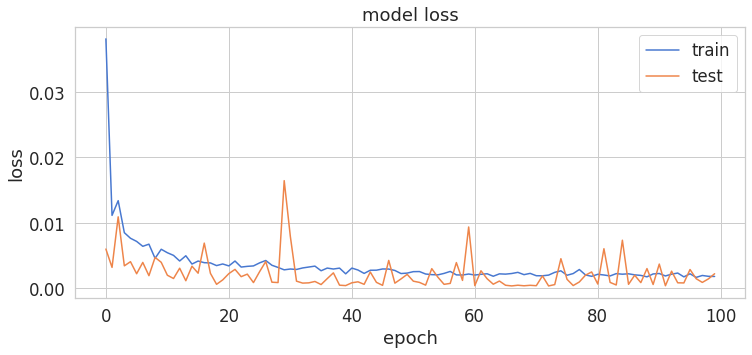

In [27]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');

In [28]:
norm_train = train[train.Class == 0].drop(columns = ['Class'])
fraud_train = train[train.Class == 1].drop(columns = ['Class'])


In [29]:
norm_train.shape

(45490, 29)

In [42]:
norm_pred = stacked_ae.predict(norm_train)
fraud_pred = stacked_ae.predict(fraud_train)

In [45]:
norm_y = np.zeros(norm_pred.shape[0])
fraud_y = np.ones(fraud_pred.shape[0])

In [46]:
# check
print(norm_pred.shape, norm_y.shape)
print(fraud_pred.shape, fraud_y.shape)

(45490, 29) (45490,)
(394, 29) (394,)


In [47]:
X = np.append(norm_pred, fraud_pred, axis = 0)
Y = np.append(norm_y, fraud_y, axis = 0)

# Neglect: ???

In [48]:
#train_x, val_x, train_y, val_y = train_test_split(rep_x, rep_y, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(X, Y)
pred_y = clf.predict(test.drop(columns=['Class']))

print ("")
print ("Classification Report: ")
print (classification_report(test['Class'], pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(test['Class'], pred_y))


Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11373
           1       0.99      0.77      0.86        98

    accuracy                           1.00     11471
   macro avg       0.99      0.88      0.93     11471
weighted avg       1.00      1.00      1.00     11471


Accuracy Score:  0.9979077674134774


# Try

In [49]:
norm_train_2 = rest[rest.Class == 0].drop(columns=['Class'])
fraud_train_2 = rest[rest.Class == 1].drop(columns = ['Class'])

In [50]:
norm_pred_2 = stacked_ae.predict(norm_train_2)
fraud_pred_2 = stacked_ae.predict(fraud_train_2)

In [51]:
norm_y_2 = np.zeros(norm_pred_2.shape[0])
fraud_y_2 = np.ones(fraud_pred_2.shape[0])

In [52]:
# check
print(norm_pred_2.shape, norm_y_2.shape)
print(fraud_pred_2.shape, fraud_y_2.shape)

(56863, 29) (56863,)
(492, 29) (492,)


In [53]:
X_2 = np.append(norm_pred_2, fraud_pred_2, axis = 0)
Y_2 = np.append(norm_y_2, fraud_y_2, axis = 0)

# Logistic Regression:

In [54]:
train_x, val_x, train_y, val_y = train_test_split(X_2, Y_2, test_size=0.25)
clf = LogisticRegression(solver="lbfgs").fit(train_x, train_y)
pred_y = clf.predict(val_x)

print ("")
print ("Classification Report: ")
print (classification_report(val_y, pred_y))

print ("")
print ("Accuracy Score: ", accuracy_score(val_y, pred_y))


Classification Report: 
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14219
         1.0       0.94      0.77      0.84       120

    accuracy                           1.00     14339
   macro avg       0.97      0.88      0.92     14339
weighted avg       1.00      1.00      1.00     14339


Accuracy Score:  0.9976288444103494


# XGB Classifier:

In [61]:
from xgboost import XGBClassifier

xgb_clf = XGBClassifier()
xgb_clf.fit(train_x, train_y, eval_metric='aucpr')

y_train_pred = xgb_clf.predict(train_x)
y_test_pred = xgb_clf.predict(val_x)




print(classification_report(y_test_pred, val_y))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14233
         1.0       0.86      0.97      0.91       106

    accuracy                           1.00     14339
   macro avg       0.93      0.99      0.96     14339
weighted avg       1.00      1.00      1.00     14339



# Random Forest:

In [64]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=100, oob_score=False)
rf_clf.fit(train_x, train_y)

y_train_pred = rf_clf.predict(train_x)
y_test_pred = rf_clf.predict(val_x)



In [65]:
print(classification_report(y_test_pred, val_y))
print(confusion_matrix(y_test_pred, val_y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14229
         1.0       0.86      0.94      0.90       110

    accuracy                           1.00     14339
   macro avg       0.93      0.97      0.95     14339
weighted avg       1.00      1.00      1.00     14339

[[14212    17]
 [    7   103]]


# CatBoost:

In [66]:
from catboost import CatBoostClassifier

cb_clf = CatBoostClassifier()
cb_clf.fit(train_x, train_y)

Learning rate set to 0.051345
0:	learn: 0.5444296	total: 71.2ms	remaining: 1m 11s
1:	learn: 0.4185168	total: 88.8ms	remaining: 44.3s
2:	learn: 0.3250390	total: 106ms	remaining: 35.2s
3:	learn: 0.2577167	total: 123ms	remaining: 30.6s
4:	learn: 0.2067491	total: 140ms	remaining: 27.9s
5:	learn: 0.1631912	total: 157ms	remaining: 25.9s
6:	learn: 0.1327289	total: 173ms	remaining: 24.6s
7:	learn: 0.1070357	total: 189ms	remaining: 23.4s
8:	learn: 0.0890691	total: 207ms	remaining: 22.8s
9:	learn: 0.0748272	total: 225ms	remaining: 22.2s
10:	learn: 0.0622540	total: 240ms	remaining: 21.6s
11:	learn: 0.0523128	total: 258ms	remaining: 21.3s
12:	learn: 0.0448288	total: 274ms	remaining: 20.8s
13:	learn: 0.0389347	total: 291ms	remaining: 20.5s
14:	learn: 0.0341197	total: 308ms	remaining: 20.2s
15:	learn: 0.0303613	total: 323ms	remaining: 19.9s
16:	learn: 0.0272283	total: 340ms	remaining: 19.7s
17:	learn: 0.0246824	total: 356ms	remaining: 19.4s
18:	learn: 0.0226326	total: 372ms	remaining: 19.2s
19:	lear

In [68]:
y_test_pred = cb_clf.predict(val_x)
print(classification_report(y_test_pred, val_y))
print(confusion_matrix(y_test_pred, val_y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14234
         1.0       0.83      0.95      0.89       105

    accuracy                           1.00     14339
   macro avg       0.92      0.98      0.94     14339
weighted avg       1.00      1.00      1.00     14339

[[14214    20]
 [    5   100]]


# LigthGBM:

In [69]:
from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier()
lgbm_clf.fit(train_x, train_y)


LGBMClassifier()

In [70]:
y_test_pred = cb_clf.predict(val_x)
print(classification_report(y_test_pred, val_y))
print(confusion_matrix(y_test_pred, val_y))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     14234
         1.0       0.83      0.95      0.89       105

    accuracy                           1.00     14339
   macro avg       0.92      0.98      0.94     14339
weighted avg       1.00      1.00      1.00     14339

[[14214    20]
 [    5   100]]
